<a href="https://colab.research.google.com/github/mafaldasalomao/DCGAN_MNIST_TENSORFLOW/blob/main/CycleGAN_Horse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercício CycleGAN (cGAN)  

> Treinar rede para transformar cavalos em zebras 

Neste exercício você deverá treinar uma rede que irá fazer a "tradução" (alteração de domínio) **de cavalos para zebras**. 

Para isso, você pode utilizar o dataset `horse2zebra`

* Mais informações sobre o dataset: https://www.tensorflow.org/datasets/catalog/cycle_gan#cycle_ganhorse2zebra

Para usar esse dataset, basta passar o nome correto dele dentro da função `tfds.load()`, substituindo assim o `apple2orange` (que usamos nas aulas anteriores) por `horse2zebra`. 

Você pode treinar por `7` épocas de começo, apenas para ter uma ideia. Recomendamos um número menor de início também pois verá que é mais demorado para treinar. 


## Importação das bibliotecas

In [ ]:
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf
tf.__version__

'2.9.2'

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-5lne53p2
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-5lne53p2
  Created wheel for tensorflow-examples: filename=tensorflow_examples-9eb657f949c2e8ec8592a9576811db38a86dcbc0_-py3-none-any.whl size=299703 sha256=4b89bc254152bef1ee030441253eaa622baae11397af3acd312befbab68d297a
  Stored in directory: /tmp/pip-ephem-wheel-cache-tvipzbmc/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/i

In [ ]:
tf.random.set_seed(789)

## Download e carregamento do dataset

- Datasets: https://www.tensorflow.org/datasets/catalog/cycle_gan

In [ ]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra', with_info = True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating trainA examples...:   0%|          | 0/1067 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete26IWR2/cycle_gan-trainA.tfrecord*...:   …

Generating trainB examples...:   0%|          | 0/1334 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete26IWR2/cycle_gan-trainB.tfrecord*...:   …

Generating testA examples...:   0%|          | 0/120 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete26IWR2/cycle_gan-testA.tfrecord*...:   0…

Generating testB examples...:   0%|          | 0/140 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete26IWR2/cycle_gan-testB.tfrecord*...:   0…

Dataset cycle_gan downloaded and prepared to ~/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0. Subsequent calls will reuse this data.


In [ ]:
treinamento_A, treinamento_B = dataset['trainA'], dataset['trainB']
teste_A, teste_B = dataset['testA'], dataset['testB']

In [ ]:
qtd_treinamento = len(treinamento_A)
qtd_treinamento

1067

In [ ]:
buffer_size = qtd_treinamento
batch_size = 1
img_largura = 256
img_altura = 256

## Funções de pré-processamento

- Recomendações do paper do CycleGAN ([link aqui](https://arxiv.org/pdf/1703.10593.pdf))

* No jitter aleatório, a imagem é redimensionada para 286x286, realizado o crop aleatório para pegar uma região 256x256 da imagem.

* Em espelhamento aleatório, a imagem é espelhada horizontalmente (esquerda / direita) de modo aleatório. 

In [ ]:
def crop_aleatorio(img):
  img_crop = tf.image.random_crop(img, size=[img_altura, img_largura, 3])
  return img_crop

In [ ]:
def normaliza(img):
  img = tf.cast(img, tf.float32)
  img = (img / 127.5) - 1
  return img

In [ ]:
def jitter_aleatorio(img):
  img = tf.image.resize(img, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  img = crop_aleatorio(img)
  img = tf.image.random_flip_left_right(img)
  return img

In [ ]:
def processa_img_treinamento(img, label):
  img = jitter_aleatorio(img)
  img = normaliza(img)
  return img

In [ ]:
def processa_img_teste(img, label):
  img = normaliza(img)
  return img

## Carregamento do dataset

Abaixo vamos realizar o carregamento das imagens para cada um dos 4 conjuntos: 

* Treinamento e Teste A (cavalos) e Treinamento e Teste B (zebras)

In [ ]:
treinamento_A = treinamento_A.cache().map(processa_img_treinamento, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(batch_size)
treinamento_B = treinamento_B.cache().map(processa_img_treinamento, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(batch_size)
teste_A = teste_A.cache().map(processa_img_teste, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(batch_size)
teste_B = teste_B.cache().map(processa_img_teste, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(batch_size)

In [ ]:
type(treinamento_A)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [ ]:
amostra_A = next(iter(treinamento_A))
amostra_B = next(iter(treinamento_B))

Cavalo com jitter aleatório


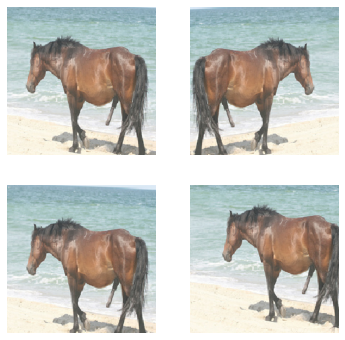

In [ ]:
print('Cavalo com jitter aleatório')
plt.figure(figsize = (6,6))
for i in range(4):
  A_jitter = jitter_aleatorio(amostra_A[0])
  plt.subplot(2, 2, i + 1)
  #plt.imshow(amostra_A[0] * 0.5 + 0.5)
  plt.imshow(A_jitter * 0.5 + 0.5)
  plt.axis('off')
plt.show()

Zebra com jitter aleatório


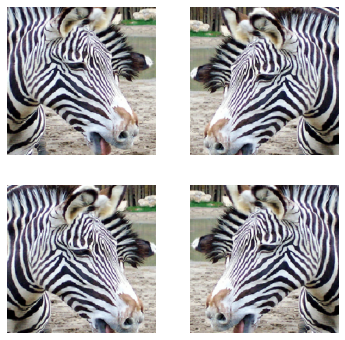

In [ ]:
print('Zebra com jitter aleatório')
plt.figure(figsize = (6,6))
for i in range(4):
  A_jitter = jitter_aleatorio(amostra_B[0])
  plt.subplot(2, 2, i + 1)
  #plt.imshow(amostra_B[0] * 0.5 + 0.5)
  plt.imshow(A_jitter * 0.5 + 0.5)
  plt.axis('off')
plt.show()

## Gerador e Discriminador

- Importar os modelos que estão no pacote [tensorflow_examples](https://github.com/tensorflow/examples) 

1. O CycleGAN do paper utiliza *instance normalization* ao invés de *batch normalization*
2. O Gerador usado é uma resnet modificada, já aqui usaremos uma U-net para tornar o processo mais simples e prático 



In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix
canais_saida = 3
gerador_g = pix2pix.unet_generator(canais_saida, norm_type = 'instancenorm')
gerador_f = pix2pix.unet_generator(canais_saida, norm_type = 'instancenorm')
discriminador_x = pix2pix.discriminator(norm_type = 'instancenorm', target = False)
discriminador_y = pix2pix.discriminator(norm_type = 'instancenorm', target = False)

Algoritmo por trás do CycleGAN:

* Há 2 geradores (G e F) e 2 discriminadores (X e Y) sendo treinados:

1. Gerador G = aprende a transformar imagem X para imagem Y  (`G:X->Y`)
2. Gerador F = aprende a transformar imagem Y para imagem X  (`G:Y->X`)
3. Discriminador D_X = aprende a diferenciar imagem X e a imagem X gerada (`X(F(Y))`)
4. Discriminador D_Y = aprende a diferenciar imagem Y e a imagem Y gerada (`Y(G(X))`)

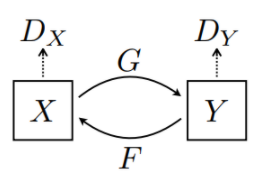

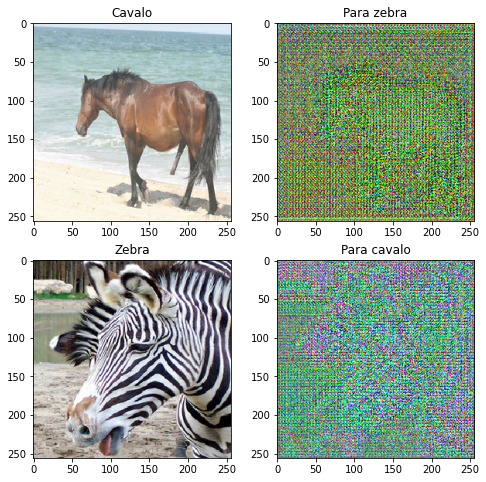

In [ ]:
B_gerada = gerador_g(amostra_A)
A_gerada = gerador_f(amostra_B)
plt.figure(figsize=(8,8))
imgs = [amostra_A, B_gerada, amostra_B, A_gerada]
titulo = ['Cavalo', 'Para zebra', 'Zebra', 'Para cavalo']
for i in range(len(imgs)):
  plt.subplot(2, 2, i + 1)
  plt.title(titulo[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * 6 + 0.5)
plt.show()

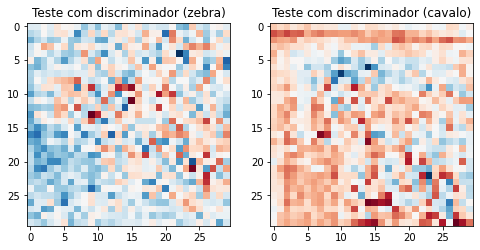

In [ ]:
plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.title('Teste com discriminador (zebra)')
plt.imshow(discriminador_y(amostra_B)[0, ..., -1], cmap = 'RdBu_r')

plt.subplot(1, 2, 2)
plt.title('Teste com discriminador (cavalo)')
plt.imshow(discriminador_x(amostra_A)[0, ..., -1], cmap = 'RdBu_r')

plt.show()

## Funções de Perda

* Diferente do Pix2Pix, com o CycleGAN não temos um conjunto de treinamento pareado, portanto não há uma garantia de que a imagem de entrada x e a imagem de referência y estejam semelhantes de algum modo. 

* Para garantir que a rede aprenda a fazer o mapeamento correto, os autores propuseram uma perda de consistência cíclica (*cycle consistency loss*)

* No mais, a perda do discriminador e do gerador são similares às usadas no Pix2Pix

In [ ]:
lambda_ = 10
loss = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [ ]:
def loss_discriminador(real, gerada):
  loss_real = loss(tf.ones_like(real), real)
  loss_gerada = loss(tf.zeros_like(gerada), gerada)
  d_loss_total = loss_real + loss_gerada
  return d_loss_total

In [ ]:
def loss_gerador(gerada):
  return loss(tf.ones_like(gerada), gerada)

> Cycle consistency loss - significa que o resultado deve ser próximo à imagem original (entrada). Exemplo: se traduzirmos uma frase de português para inglês, e então traduzirmos novamente de inglês para português, o resultado da frase deve ser igual ao da frase original.

O funcionamento dessa perda se dá:

* imagem X é passada para o gerador G que produz a imagem gerada Y^
* imagem gerada Ŷ é passada ao gerador F que produz a imagem X^ "ciclada" (cycled)
* o Mean Absolute Error é calculado entre X e X^


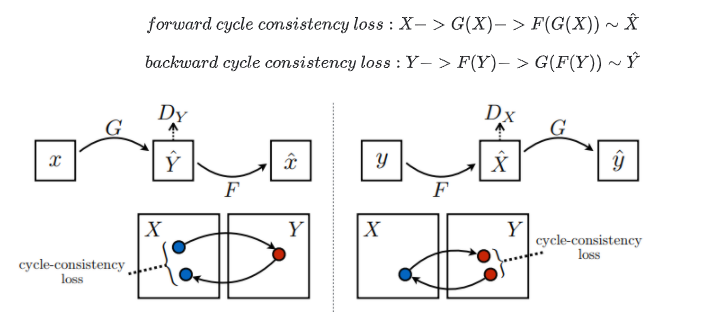

In [ ]:
def cycle_loss(img_real, img_cycled):
  loss1 = tf.reduce_mean(tf.abs(img_real - img_cycled))
  return lambda_ * loss1

Ou seja:

* o gerador G é responsável por traduzir imagem X para Y.

* o Identity loss diz o seguinte: e você fornecer a imagem Y para gerador G isso deve produzir a imagem real Y ou algo próximo à imagem Y.

* se você por exemplo rodar o modelo de laranja->maçã em uma maçã ou se rodar o modelo de maçã->laranja em uma laranja, a imagem não deve ser muito modificada já que a imagem já contém aquela classe específica 

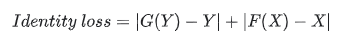

In [ ]:
def loss_identity(img_real, img_igual):
  loss = tf.reduce_mean(tf.abs(img_real - img_igual))
  return lambda_ * 0.5 * loss

Mais sobre identity loss
* https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/issues/322
* https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/pull/362

## Optimizers

In [ ]:
lr = 0.0002
beta1, beta2 = 0.5, 0.999

In [ ]:
gerador_g_optimizer = tf.keras.optimizers.Adam(lr, beta_1 = beta1, beta_2 = beta2)
gerador_f_optimizer = tf.keras.optimizers.Adam(lr, beta_1 = beta1, beta_2 = beta2)

discriminador_x_optimizer = tf.keras.optimizers.Adam(lr, beta_1 = beta1, beta_2 = beta2)
discriminador_y_optimizer = tf.keras.optimizers.Adam(lr, beta_1 = beta1, beta_2 = beta2)

In [ ]:
checkpoint_dir = "./checkpoints/train"
checkpoint = tf.train.Checkpoint(generator_g = gerador_g,
                                 generator_f = gerador_f,
                                 discriminator_x = discriminador_x,
                                 discriminator_y = discriminador_y,
                                 generator_g_optimizer=gerador_g_optimizer,
                                 generator_f_optimizer = gerador_f_optimizer,
                                 discriminator_x_optimizer = discriminador_x_optimizer,
                                 discriminator_y_optimizer = discriminador_y_optimizer)
checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)
if checkpoint_manager.latest_checkpoint:
  checkpoint.restore(checkpoint_manager.latest_checkpoint)
  print('Restaurado para o último checkpoint!')

## Treinamento

1. As predições sendo obtidas pelos geradores
2. As perdas calculadas
3. Calculado o gradiente usando backpropagation
4. Aplicado o gradiente ao optimizer


In [ ]:
epochs = 7
def gerar_imagens(modelo, teste_entrada):
  gerada = modelo(teste_entrada)
  plt.figure(figsize = (8,6))
  lista_imgs = [teste_entrada[0], gerada[0]]
  titulo = ['Imagem entrada (original)', 'Imagem saída (gerada)']
  for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.title(titulo[i])
    plt.imshow(lista_imgs[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
@tf.function
def etapa_treinamento(real_x, real_y):
  with tf.GradientTape(persistent=True) as tape:
    # Gerador G traduz X -> Y
    # Gerador F traduz Y -> X

    # Cavalo para zebra fake
    fake_y = gerador_g(real_x, training = True)
    # Ciclo (cavalo para zebra fake para cavalo fake) x -> y -> x
    cycled_x = gerador_f(fake_y, training = True)

    # Zebra para cavalo fake
    fake_x = gerador_f(real_y, training = True)
    # Ciclo (zebra para cavalo fake para zebra fake) y -> x -> y
    cycled_y = gerador_g(fake_x, training = True)

    # Mapeamento de identidade
    igual_x = gerador_f(real_x, training = True)
    igual_y = gerador_g(real_y, training = True)

    # Saída do discriminador
    discriminador_real_x = discriminador_x(real_x, training = True)
    discriminador_fake_x = discriminador_x(fake_x, training = True)
    
    discriminador_real_y = discriminador_y(real_y, training = True)
    discriminador_fake_y = discriminador_y(fake_y, training = True)

    # Cálculo das perdas
    gerador_g_loss = loss_gerador(discriminador_fake_y)
    gerador_f_loss = loss_gerador(discriminador_fake_x)
    cycle_loss_total = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)
    total_gerador_g_loss = gerador_g_loss + cycle_loss_total + loss_identity(real_y, igual_y)
    total_gerador_f_loss = gerador_f_loss + cycle_loss_total + loss_identity(real_x, igual_x)
    discriminador_x_loss = loss_discriminador(discriminador_real_x, discriminador_fake_x)
    discriminador_y_loss = loss_discriminador(discriminador_real_y, discriminador_fake_y)
  
  # Calcula os gradients para gerador e discriminador 
  gerador_g_gradients = tape.gradient(total_gerador_g_loss, gerador_g.trainable_variables)
  gerador_f_gradients = tape.gradient(total_gerador_f_loss, gerador_f.trainable_variables)
  discriminador_x_gradients = tape.gradient(discriminador_x_loss, discriminador_x.trainable_variables)
  discriminador_y_gradients = tape.gradient(discriminador_y_loss, discriminador_y.trainable_variables)
  
  # Aplica os gradients para o optimizer
  gerador_g_optimizer.apply_gradients(zip(gerador_g_gradients, gerador_g.trainable_variables))
  gerador_f_optimizer.apply_gradients(zip(gerador_f_gradients, gerador_f.trainable_variables)) 
  discriminador_x_optimizer.apply_gradients(zip(discriminador_x_gradients, discriminador_x.trainable_variables))
  discriminador_y_optimizer.apply_gradients(zip(discriminador_y_gradients, discriminador_y.trainable_variables))

In [ ]:
def treinar(treinamento_A, treinamento_B, gerador_g, etapas):
  for epoch in range(epochs):
    inicio = time.time()

    n = 0
    for img_x, img_y in tf.data.Dataset.zip((treinamento_A, treinamento_B)):
      etapa_treinamento(img_x, img_y)
      if n % 10 == 0:
        print('.', end = '')
      n += 1

    clear_output(wait = True)
    gerar_imagens(gerador_g, amostra_A)
    print('Tempo levado para época {}: {} segundos\n'.format(epoch + 1, time.time() - inicio))

    if (epoch + 1) % 5 == 0:
      checkpoint_dir_salvo = checkpoint_manager.save()
      print('Checkpoint salvo')
    
    gerador_g.save_weights('modelo_cyclegan.h5')

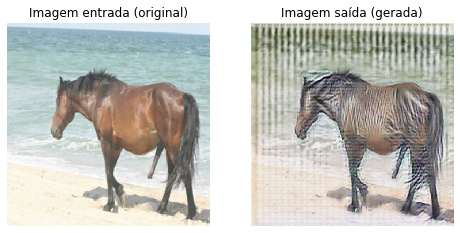

Tempo levado para época 10: 466.808069229126 segundos

Checkpoint salvo


In [ ]:
treinar(treinamento_A, treinamento_B, gerador_g, epochs)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

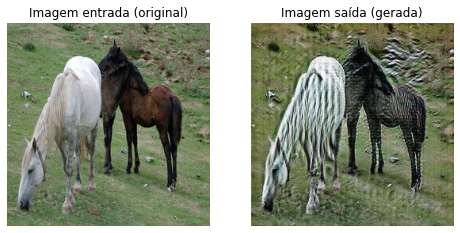

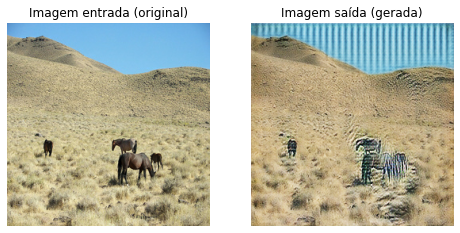

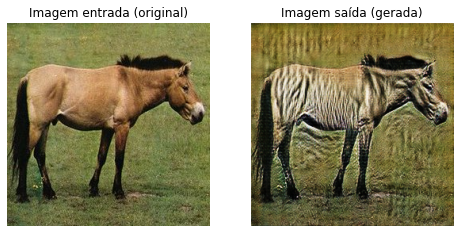

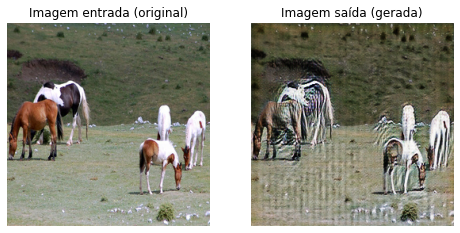

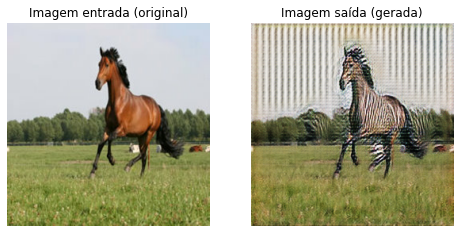

In [ ]:
for entrada in teste_A.take(5):
  gerar_imagens(gerador_g, entrada)

Códigos de referência:
* https://github.com/keras-team/keras-io/blob/master/examples/generative/ipynb/cyclegan.ipynb
* https://keras.io/examples/generative/cyclegan/

---